# Topic modelling for Dreamachine dataset

Author : Romy Beauté\
Date created : 13/05/2024\
Last modified : 23/09/2025\
Corresp : r.beaut@sussex.ac.uk

Selection of sentence transformer embedding models :
https://www.sbert.net/docs/pretrained_models.html

The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality



### imports and global setup

In [40]:

import torch
import os
import numpy as np
import nltk
import sys
import pandas as pd
import nltk
import re
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from umap import UMAP
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
from bertopic.representation import KeyBERTInspired, LlamaCPP,MaximalMarginalRelevance
import datamapplot
import random



# Global random seed for reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): #will be false on mac but true with gpus
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Environment setup
os.environ["TOKENIZERS_PARALLELISM"] = "True"
nltk.download('stopwords')

# Add project root to path
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)  
sys.path.append(project_root)

# Import project modules
from src.preprocessor import split_sentences
from src.utils import get_params_grid, calculate_coherence,calculate_embedding_coherence
from src.model import setup_model, setup_umap, setup_hdbscan
from src.llama_CPP_custom import *
from configs.dreamachine2 import config


dataset = "DREAMACHINE"
condition = "HS"

print(f"Current working directory: {os.getcwd()}")
BOX_DIR = os.path.join(os.path.expanduser("~"), "Library", "CloudStorage", "Box-Box", "TMDATA")
print(f"Retrieving data from BOX, locally stored at: {BOX_DIR}")
DATA_DIR = os.path.join(BOX_DIR, dataset)
print(f"Data directory: {DATA_DIR}")
results_dir = os.path.join(project_root, "EVAL",dataset.lower())


Current working directory: /Users/rb666/Projects/MOSAIC/scripts
Retrieving data from BOX, locally stored at: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA
Data directory: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA/DREAMACHINE


[nltk_data] Downloading package stopwords to /Users/rb666/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Define parameters for current run


In [41]:

sentences = True
random_seed = SEED # uses the global seed 

# Outlier reduction settings
reduce_outliers = True
# outlier_strategy = 'embeddings' 
# outlier_threshold = 0.65

outlier_strategy = 'probabilities' 
outlier_threshold = 0.15


### Load and preprocess data


In [42]:

reports_path = os.path.join(DATA_DIR, f"{condition}_reflections_APIcleaned.csv")
print("Using data from:", reports_path)

# load data and divide into sentences if needed
df_reports = pd.read_csv(reports_path)['cleaned_reflection'].dropna().reset_index(drop=True)
df_reports


Using data from: /Users/rb666/Library/CloudStorage/Box-Box/TMDATA/DREAMACHINE/HS_reflections_APIcleaned.csv


0      Intense chaos. And then my mind checked out an...
1                                            Good stuff.
2      A pattern of red and white lights that flashed...
3      I went back to many hard and mostly beautiful ...
4                                                 Hello.
                             ...                        
328    Changing temperature of my body with the light...
329                                 Pleasure & intrigue.
330                            Travelling through space.
331    I thought a lot about Rand's journey into Rhui...
332    The visual here doesn't look anything like wha...
Name: cleaned_reflection, Length: 333, dtype: object

### Pre-processing


In [43]:
#divide in sentences if needed
if sentences:
    df_reports = split_sentences(df_reports)[0]
print(f"\nSuccessfully loaded and processed {len(df_reports)} sentences.")


#remove sentences defined as too short
min_words = 2 #threshold for minimum words in a sentence
#print all sentences that contain only min_words word
for i, sentence in enumerate(df_reports):
    if len(sentence.split()) < min_words:
        print(sentence)

#print the amount of sentences that have less than min_words words
short_sentences = [sentence for sentence in df_reports if len(sentence.split()) < min_words]
print(f"\nThere are {len(short_sentences)} sentences with less than {min_words} words.\n")

# Remove sentences with less than 2 words
df_reports = [sentence for sentence in df_reports if len(sentence.split()) >= min_words]
print(f"After removing short sentences, {len(df_reports)} sentences remain.")

# Remove duplicate sentences if any
seen = set()
df_reports = [s for s in df_reports if not (s in seen or seen.add(s))]
print(f"After removing duplicates, {len(df_reports)} remain.")


Successfully loaded and processed 736 sentences.
Hello.
Devtest.
Confusion.
Vast.
Immense.
Tessellations.
Hexagons.
Joy.
Starfields.
devtest
l
it
Beautiful!
Thanks!
Euphoria
Unease
Bizarre.
Everything.
Pareidolia.
Soothed.
Tired.
Joy.
Calm
Warm
h
cakm
Anxiety.
l8
Vertigo.
Peace.
Peace.
Sunlight.
True.

There are 33 sentences with less than 2 words.

After removing short sentences, 703 sentences remain.
After removing duplicates, 700 remain.


### Setup models (sentence transformer and countvectorizer) and generate embeddings

In [44]:
# Models setup (from configs)
print("Setting up models and generating embeddings...")

embedding_model = SentenceTransformer(config.transformer_model)
print("Using embedding model:", config.transformer_model)
embeddings = embedding_model.encode(df_reports, show_progress_bar=True)

vectorizer_model = CountVectorizer(
    ngram_range=config.ngram_range, 
    stop_words=list(config.extended_stop_words),
    max_df=config.max_df,
    min_df=config.min_df
)

print("Embeddings and vectorizer ready.")

Setting up models and generating embeddings...
Using embedding model: Qwen/Qwen3-Embedding-0.6B


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Embeddings and vectorizer ready.


### Train BERTopic model 

In [45]:
### Chose either to load best params from grid search, optuna or use defaults tailored ones from the config file

param_selection = "optuna" #can be "optuna", "default", or "grid_search"
target_trial_number = None #item nb of a specific trial, or None to load the best one
sanitized_model_name = config.transformer_model.replace('/', '_') #name of the transformer model with '/' replaced by '_'


if param_selection=="optuna":
    if target_trial_number is None:
        params = pd.read_csv(os.path.join(results_dir,f"OPTUNA_results_{condition}_{'sentences' if sentences else ''}_{sanitized_model_name}_2.csv")).sort_values(by='embedding_coherence', ascending=False).reset_index(drop=True)
        chosen_params = params.iloc[0]
        print("Best parameters loaded from optuna:")
        print(chosen_params)
    else:
        params = pd.read_csv(os.path.join(results_dir,f"OPTUNA_results_{condition}_{'sentences' if sentences else ''}_{sanitized_model_name}.csv"))
        chosen_params_row = params[params['trial_number'] == target_trial_number]
        # Check if the trial was actually found in the file
        if not chosen_params_row.empty:
            # .iloc[0] selects the first row of the filtered result, which gives us the parameter series
            chosen_params = chosen_params_row.iloc[0]
            print(f"Parameters successfully loaded for Optuna trial number: {target_trial_number}")
            print(chosen_params)
        else:
            raise ValueError(f"Error: Trial number {target_trial_number} was not found in the results file.")

elif param_selection=="grid_search":
    params = pd.read_csv(os.path.join(results_dir,f"GS_results_{condition}_{'sentences' if sentences else ''}.csv")).sort_values(by='embedding_coherence', ascending=False).reset_index(drop=True)
    chosen_params = params.iloc[0]
    print("Best parameters loaded from grid search:")
    print(chosen_params)
elif param_selection=="default":
    print(f"Loading default parameters for condition: {condition}")
    chosen_params = config.get_default_params(condition)
    print("Default parameters loaded:")
    print(pd.Series(chosen_params))
else:
    raise ValueError("param_selection must be 'optuna', 'default', or 'grid_search'")


Best parameters loaded from optuna:
trial_number             65.000000
embedding_coherence       0.611199
n_components             13.000000
n_neighbors              18.000000
min_dist                  0.020000
min_cluster_size         10.000000
min_samples               8.000000
coherence_score           0.447209
coherence_score_umass   -15.806756
n_topics                 12.000000
Name: 0, dtype: float64


In [46]:


# --- Setup UMAP and HDBSCAN models ---
umap_model = setup_umap(
    n_neighbors=int(chosen_params['n_neighbors']),
    n_components=int(chosen_params['n_components']),
    min_dist=float(chosen_params['min_dist']),
    random_seed=random_seed
)


hdbscan_model = setup_hdbscan(
    min_cluster_size=int(chosen_params['min_cluster_size']),
    min_samples=int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
)

# Initialise and fit the main Topic model
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    # representation_model=representation_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words= config.top_n_words,#int(chosen_params['top_n_words']), #how many key words are generated for each topic's default representation
    nr_topics="auto",
    verbose=True,
    calculate_probabilities=True # Needed for the 'probabilities' outlier reduction strategy
)

topics, probs = topic_model.fit_transform(df_reports, embeddings) #run main training step


2025-10-03 14:29:35,402 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-03 14:29:36,760 - BERTopic - Dimensionality - Completed ✓
2025-10-03 14:29:36,761 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-03 14:29:36,792 - BERTopic - Cluster - Completed ✓
2025-10-03 14:29:36,792 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-10-03 14:29:36,810 - BERTopic - Representation - Completed ✓
2025-10-03 14:29:36,810 - BERTopic - Topic reduction - Reducing number of topics
2025-10-03 14:29:36,813 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-03 14:29:36,826 - BERTopic - Representation - Completed ✓
2025-10-03 14:29:36,826 - BERTopic - Topic reduction - Reduced number of topics from 17 to 12


### Check topic and embedding coherence

In [47]:
# Calculate initial coherence score
initial_coherence, _ = calculate_coherence(topic_model, df_reports)
embedding_coherence = calculate_embedding_coherence(topic_model, df_reports, embeddings)
print(f"Initial Word-Based Coherence Score (C_v): {initial_coherence:.4f}")
print(f"Initial Embedding Coherence Score: {embedding_coherence:.4f}") # Display the new score
print(f"Initial number of topics extracted: {len(np.unique(topics))}")
print(f"Initial number of outlier sentences: {len([t for t in topics if t == -1])}")

Number of valid topics used for coherence calculation (excludes outliers -1): 11
Initial Word-Based Coherence Score (C_v): 0.4472
Initial Embedding Coherence Score: 0.6112
Initial number of topics extracted: 12
Initial number of outlier sentences: 218


### Add representations

In [48]:
# KeyBERT
keybert = KeyBERTInspired()

# MMR
# mmr = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert
    # "MMR": mmr,
}

print("\nUpdating model with KeyBERT and MMR representations...")
topic_model.update_topics(df_reports, representation_model=representation_model)
print("Update complete.")


Updating model with KeyBERT and MMR representations...
Update complete.


### Check topics that were generated, their preliminary representation, and check which docs (sentences) were used for representation

In [49]:
topic_model.get_topic_info() #get an overview of the topics found

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,218,-1_the_and_to_of,"[the, and, to, of, it, was, in, my, were, music]","[feeling, thought, feel, then, my, this, felt,...","[my, were, music, like, experience, felt, time...",[A totally immersive experience; it felt like ...
1,0,226,0_of_and_the_saw,"[of, and, the, saw, like, in, as, was, through...","[kaleidoscopic, kaleidoscope, colourful, colou...","[saw, like, shapes, colours, patterns, blue, k...",[I saw many kinds of patterns from sparks to g...
2,1,66,1_it_was_and_to,"[it, was, and, to, felt, experience, my, memor...","[feeling, memories, remembered, emotions, sens...","[felt, experience, memories, feeling, back, ol...",[At times it felt like I was back in the womb....
3,2,42,2_calm_peace_and_relaxation,"[calm, peace, and, relaxation, sense, joy, rel...","[calm, calming, tranquility, relaxing, stillne...","[calm, peace, relaxation, relaxing, music, pea...","[Peace and contentment., Utter peace and happi..."
4,3,30,3_journey_towards_through_forward,"[journey, towards, through, forward, moving, f...","[journey, through, moving, motion, towards, tr...","[journey, through, moving, speed, highway, que...","[A portal moving towards me, away from me, thr..."
5,4,26,4_experience_it_very_amazing,"[experience, it, very, amazing, thank, awesome...","[wonderful, experience, amazing, experienced, ...","[experience, amazing, wonderful, overall, good...","[Fabulous experience., Thanks for the experien..."
6,5,25,5_felt_relaxed_and_was,"[felt, relaxed, and, was, safe, also, sense, v...","[relaxation, relax, sensations, comforted, rel...","[relaxed, safe, peaceful, euphoria, relaxation...","[I felt relaxed, safe, and excited at the star..."
7,6,17,6_asleep_quite_dreamlike_dreaming,"[asleep, quite, dreamlike, dreaming, conscious...","[semiconscious, dreaming, dreamlike, asleep, d...","[asleep, dreamlike, dreaming, consciousness, d...",[I did not have profound thoughts during the e...
8,7,17,7_the_on_my_to,"[the, on, my, to, me, eyes, light, of, lights,...","[lights, light, eyes, eye, intensity, lighting...","[eyes, light, lights, intensity, flashing, mas...",[I would have liked a slight diffusion on the ...
9,8,12,8_thoughts_my_what_couldn,"[thoughts, my, what, couldn, thinking, mind, m...","[distraction, distracted, mind, conscious, tho...","[thoughts, thinking, mind, meditate, brain, di...",[I think when it became overwhelming my brain ...


In [50]:

if reduce_outliers:
    print(f"\nReducing outliers using the '{outlier_strategy}' strategy with threshold {outlier_threshold}...")
    new_topics = topic_model.reduce_outliers(df_reports, topics, strategy=outlier_strategy,probabilities=probs,threshold=outlier_threshold)

    # update the topics variable for subsequent steps
    topics = new_topics
    
    # update the model with the new topic assignments
    topic_model.update_topics(df_reports, topics=topics)

    print(f"Remaining outliers after reduction: {len([t for t in topics if t == -1])}")
    
    # re-calculate coherence to see the impact after outlier reduction
    final_coherence, _ = calculate_coherence(topic_model, df_reports)
    print(f"Coherence Score after outlier reduction: {final_coherence}")
    embedding_coherence = calculate_embedding_coherence(topic_model, df_reports, embeddings)
    print(f"Embedding Coherence Score after outlier reduction: {embedding_coherence:.4f}") # Display the new score
    print(f"Number of topics after outlier reduction: {len(np.unique(topics))}\n")
    topic_model.get_topic_info() #get an overview of the topics found

2025-10-03 14:29:45,092 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.



Reducing outliers using the 'probabilities' strategy with threshold 0.15...
Remaining outliers after reduction: 66
Number of valid topics used for coherence calculation (excludes outliers -1): 11
Coherence Score after outlier reduction: 0.398601828340271
Embedding Coherence Score after outlier reduction: 0.5995
Number of topics after outlier reduction: 12



In [51]:
topic_model.get_topic_info() #get an overview of the topics found

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,-1,66,-1_the_it_music_and,"[the, it, music, and, to, would, of, my, an, w...","[feeling, thought, feel, then, my, this, felt,...","[my, were, music, like, experience, felt, time...",[A totally immersive experience; it felt like ...
1,0,297,0_of_and_the_saw,"[of, and, the, saw, in, like, was, to, through...","[kaleidoscopic, kaleidoscope, colourful, colou...","[saw, like, shapes, colours, patterns, blue, k...",[I saw many kinds of patterns from sparks to g...
2,1,133,1_it_was_to_and,"[it, was, to, and, the, my, felt, experience, ...","[feeling, memories, remembered, emotions, sens...","[felt, experience, memories, feeling, back, ol...",[At times it felt like I was back in the womb....
3,2,42,2_calm_peace_and_relaxation,"[calm, peace, and, relaxation, sense, joy, rel...","[calm, calming, tranquility, relaxing, stillne...","[calm, peace, relaxation, relaxing, music, pea...","[Peace and contentment., Utter peace and happi..."
4,3,32,3_journey_through_towards_forward,"[journey, through, towards, forward, moving, t...","[journey, through, moving, motion, towards, tr...","[journey, through, moving, speed, highway, que...","[A portal moving towards me, away from me, thr..."
5,4,28,4_experience_very_it_good,"[experience, very, it, good, interesting, amaz...","[wonderful, experience, amazing, experienced, ...","[experience, amazing, wonderful, overall, good...","[Fabulous experience., Thanks for the experien..."
6,5,28,5_felt_and_relaxed_was,"[felt, and, relaxed, was, safe, also, of, sens...","[relaxation, relax, sensations, comforted, rel...","[relaxed, safe, peaceful, euphoria, relaxation...","[I felt relaxed, safe, and excited at the star..."
7,6,18,6_asleep_quite_dreamlike_had,"[asleep, quite, dreamlike, had, dreaming, drif...","[semiconscious, dreaming, dreamlike, asleep, d...","[asleep, dreamlike, dreaming, consciousness, d...",[I did not have profound thoughts during the e...
8,7,22,7_the_on_to_my,"[the, on, to, my, me, eyes, focused, light, of...","[lights, light, eyes, eye, intensity, lighting...","[eyes, light, lights, intensity, flashing, mas...",[I would have liked a slight diffusion on the ...
9,8,13,8_my_mind_thoughts_started,"[my, mind, thoughts, started, what, couldn, th...","[distraction, distracted, mind, conscious, tho...","[thoughts, thinking, mind, meditate, brain, di...",[I think when it became overwhelming my brain ...


In [52]:
# Get the topic information DataFrame which contains all representations
topic_info_df = topic_model.get_topic_info()

print("--- Keywords from c-TF-IDF, KeyBERT and MMR Representations ---")

# Iterate over each row in the DataFrame
for index, row in topic_info_df.iterrows():
    topic_id = row['Topic']
    
    # Skip the outlier topic
    if topic_id == -1:
        continue
        
    # CORRECTED: Directly access the columns, as they already contain the list of keywords
    ctfidf_keywords = row['Representation']
    keybert_keywords = row['KeyBERT']
    # mmr_keywords = row['MMR']
    
    # Print the keywords for the current topic
    print(f"\nTopic {topic_id}:")
    print(f"  - c-TF-IDF: {ctfidf_keywords}")
    print(f"  - KeyBERT: {keybert_keywords}")
    # print(f"  - MMR:     {mmr_keywords}")

print("\n" + "="*80 + "\n")

--- Keywords from c-TF-IDF, KeyBERT and MMR Representations ---

Topic 0:
  - c-TF-IDF: ['of', 'and', 'the', 'saw', 'in', 'like', 'was', 'to', 'through', 'at']
  - KeyBERT: ['kaleidoscopic', 'kaleidoscope', 'colourful', 'colours', 'colors', 'sky', 'shapes', 'colour', 'blue', 'shape']
  - MMR:     ['saw', 'like', 'shapes', 'colours', 'patterns', 'blue', 'kaleidoscope', 'stars', 'moving', 'geometric']

Topic 1:
  - c-TF-IDF: ['it', 'was', 'to', 'and', 'the', 'my', 'felt', 'experience', 'of', 'but']
  - KeyBERT: ['feeling', 'memories', 'remembered', 'emotions', 'sensation', 'felt', 'feel', 'my', 'there', 'experiences']
  - MMR:     ['felt', 'experience', 'memories', 'feeling', 'back', 'old', 'place', 'sense', 'strong', 'really']

Topic 2:
  - c-TF-IDF: ['calm', 'peace', 'and', 'relaxation', 'sense', 'joy', 'relaxing', 'music', 'peaceful', 'tranquility']
  - KeyBERT: ['calm', 'calming', 'tranquility', 'relaxing', 'stillness', 'serenity', 'relaxation', 'peaceful', 'peace', 'peacefulness']
 

# Update model with LLAMA 3 for Topic Labelling

In [53]:
print("\nSetting up Llama3 for topic representation...")

# LLama setup
model_path = hf_hub_download(
    repo_id="NousResearch/Meta-Llama-3-8B-Instruct-GGUF",
    filename="Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
)

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n","Label:","Topic name:","Keywords:","(Note:","Note:","The label is:"],verbose=False)


Setting up Llama3 for topic representation...


llama_context: n_ctx_per_seq (4096) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f16                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64  

In [54]:
pipeline_kwargs = {
    "max_tokens": 25, 
    "temperature": 0.4,
    "repeat_penalty": 1.15
}

prompt = """Below are documents and keywords that describe a single topic.

DOCUMENTS:
[DOCUMENTS]

KEYWORDS:
- [KEYWORDS]


TASK:
Generate a single, scientific label that summarises the topic.

RULES:
- The label must be in Title Case.
- It must be concise (max 10 words).
- It must reflect directly reported phenomena.

Only return the label itself, without any additional text or punctuation.


LABEL:
"""


prompt_custom = """Below are sentences and keyword sets that describe a single topic.

SENTENCES:
[SENTENCES]

KEYWORDS:
- [KEYWORDS]
- [KEYBERT_KEYWORDS]

TASK:
Uses information from the SENTENCES and the KEYWORDS to generate a single, scientific label that summarises the topic.

RULES:
- The label must be in Title Case.
- It must be concise but precise (max 10 words).
- It must reflect directly reported phenomena.

Only return the label itself, without any additional text or punctuation.


LABEL:
"""



llm_model = LlamaCPP(llm, prompt=prompt,nr_docs=10,pipeline_kwargs=pipeline_kwargs,diversity=0.3)
llm_model_custom = PhenoLabeler(llm, prompt=prompt_custom,nr_docs=10,pipeline_kwargs=pipeline_kwargs,diversity=0.3,verbose=False) #set verbose to True to see which sentences and keywords have been used as LLM input
# llm_model_custom2 = MultiKeywordLLM(llm, prompt=prompt_custom, pipeline_kwargs=pipeline_kwargs,nr_docs=10)

# Define the representation model using our custom class
representation_model = {"LLM": llm_model,"LLM_Custom": llm_model_custom}#,"LLM_Custom2": llm_model_custom2}

print("Updating topic representations with custom Llama3 prompt...")
topic_model.update_topics(df_reports, representation_model=representation_model)
print("Initial label generation complete.\n")


Updating topic representations with custom Llama3 prompt...


100%|██████████| 12/12 [00:18<00:00,  1.53s/it]

Initial label generation complete.



In [55]:
topic_info_df = topic_model.get_topic_info()


print("--- Comparison of LLM vs. LLM_Custom Labels 1 & 2 ---")

# Iterate over each topic in the DataFrame
for index, row in topic_info_df.iterrows():
    topic_id = row['Topic']
    
    # Skip the outlier topic at the top of the DataFrame
    if topic_id == -1:
        continue
        
    # --- Clean the label from the standard 'LLM' column ---
    # The label is the first item in a list, so we select it.
    try:
        llm_label = row['LLM'][0].strip()
    except (TypeError, IndexError):
        llm_label = "Not available"

    # --- Clean the label from our 'LLM_Custom' column ---
    # The label is the first line of a messy string, so we split by newline and take the first part.
    try:
        llm_custom_label = row['LLM_Custom'][0].strip()
    except AttributeError:
        llm_custom_label = "Not available" # Handles case where the cell is empty (NaN)

    # try:
    #     llm_custom_label2 = row['LLM_Custom2'].split('\n')[0].strip()
    # except AttributeError:
    #     llm_custom_label2 = "Not available" # Handles case where the cell is empty (NaN)
        
    # --- Print the clean, side-by-side comparison ---
    print(f"\nTopic {topic_id}:")
    print(f"  - {'LLM:'.ljust(15)} {llm_label}")
    print(f"  - {'LLM_Custom:'.ljust(15)} {llm_custom_label}")
    # print(f"  - {'LLM_Custom2:'.ljust(15)} {llm_custom_label2}")

print("\n" + "="*80 + "\n")


--- Comparison of LLM vs. LLM_Custom Labels 1 & 2 ---

Topic 0:
  - LLM:            Perceptual Experience of Multicolored Patterns and Shapes
  - LLM_Custom:     Vivid Visualizations of the Universe and Cosmic Phenomena

Topic 1:
  - LLM:            Subjective Experience of Altered States and Memory Recall
  - LLM_Custom:     Subjective Experience of Emotional and Sensory States

Topic 2:
  - LLM:            Meditative Music and Light Experience
  - LLM_Custom:     Relaxation and Peaceful Sensory Experience

Topic 3:
  - LLM:            Perceptual Experience of Time and Space Travel
  - LLM_Custom:     Space Travel Experience and Perception

Topic 4:
  - LLM:            Positive Unique Life Experience
  - LLM_Custom:     Unique and Satisfying Life Experience

Topic 5:
  - LLM:            Spiritual Experience of Euphoria and Deep Relaxation
  - LLM_Custom:     Meditative Experience of Deep Relaxation and Euphoria

Topic 6:
  - LLM:            Lucid Dreaming and Hypnagogic States
  - LLM

### Process and apply topic labels generated by Llama3


In [56]:
llm_labels_raw = [label[0][0] for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [re.sub(r'\s+', ' ', label.split("\n")[0].replace('"', '')).strip() for label in llm_labels_raw]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
print(llm_labels)

unique_topics = sorted(set(topics))
base_topic_labels = {topic_id: llm_labels[i] for i, topic_id in enumerate(unique_topics) if topic_id != -1}
topic_model.set_topic_labels(base_topic_labels)
print("Base labels have been set.")



['Psychoacoustic Sensory Experience in a Dream Machine', 'Perceptual Experience of Multicolored Patterns and Shapes', 'Subjective Experience of Altered States and Memory Recall', 'Meditative Music and Light Experience', 'Perceptual Experience of Time and Space Travel', 'Positive Unique Life Experience', 'Spiritual Experience of Euphoria and Deep Relaxation', 'Lucid Dreaming and Hypnagogic States', 'Visual Sensitivity to Flashing Light Intensity', "Mind's Difficulty in Focusing and Overthinking", 'Psychedelic Experience and Trauma Processing', 'Near-Death Experience and Rebirth Phenomenology']
Base labels have been set.


In [57]:
# #Manual labels to keep consistent with previous analyses
# topic_model.set_topic_labels({0: "Visual Perception of Kaleidoscopic Patterns and Colors",
#                               1: "Out-of-Body Experiences and Cosmic Dream-Like Consciousness",
#                               2: "Mindfulness and Music Based Sensory Experience for Calm and Peace",
#                               3: "Experience of Time and Space Distortions",
#                               5: "Nostalgic Memory Recall Phenomenon",
#                               6: "Spiritual or Meditative Experience with Euphoric Sensations",
#                               7: "Visual Sensitivity to Flashing Light Intensity",
#                               9: "Phenomenological Experience of Disorientation and Anxiety",
#                               10: "Near-Death Experience and Existential Reflections",
#                               11: "Synesthetic Sensory and Emotional Experience"})



In [58]:
final_topic_info = topic_model.get_topic_info()
final_labels_map = {-1: "Unlabelled"}
for _, row in final_topic_info.iterrows():
    if row['Topic'] != -1:
        final_labels_map[row['Topic']] = row['CustomName']

all_labels = [final_labels_map.get(t, f"Topic {t}") for t in topics]
print(f"Final 'all_labels' list created for visualizations with {len(all_labels)} entries.")


Final 'all_labels' list created for visualizations with 700 entries.


In [59]:
final_topic_info = topic_model.get_topic_info()

# Create a small DataFrame with just the topic number and the final name
# We filter out the outlier topic (-1) for a clean list of actual topics
final_labels_df = final_topic_info[final_topic_info.Topic != -1][['Topic', 'CustomName']]

# For any topics you didn't manually set, we'll fill in the original keyword-based name
final_labels_df['CustomName'] = final_labels_df['CustomName'].fillna(final_topic_info['Name'])


print("--- Final List of Topics and Their Curated Labels ---")

# Print the DataFrame as a clean, index-free string
print(final_labels_df.to_string(index=False))

--- Final List of Topics and Their Curated Labels ---
 Topic                                                CustomName
     0 Perceptual Experience of Multicolored Patterns and Shapes
     1 Subjective Experience of Altered States and Memory Recall
     2                     Meditative Music and Light Experience
     3            Perceptual Experience of Time and Space Travel
     4                           Positive Unique Life Experience
     5      Spiritual Experience of Euphoria and Deep Relaxation
     6                      Lucid Dreaming and Hypnagogic States
     7            Visual Sensitivity to Flashing Light Intensity
     8            Mind's Difficulty in Focusing and Overthinking
     9              Psychedelic Experience and Trauma Processing
    10           Near-Death Experience and Rebirth Phenomenology


### Visualisation

Calculating medoids: 100%|██████████| 11/11 [00:00<00:00, 668.45it/s]


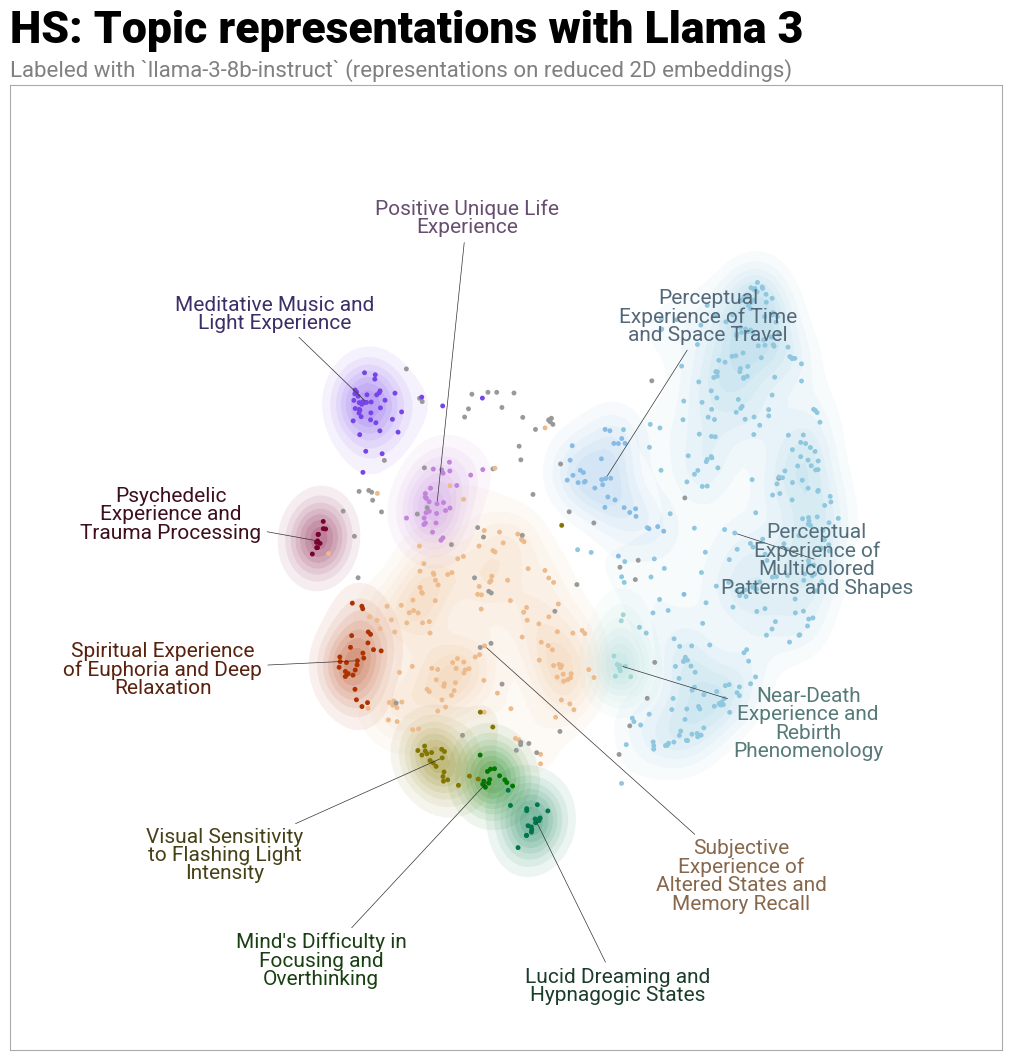

In [60]:
# Basic visu (to compare with visu before LLM labelling)
display(topic_model.visualize_documents(df_reports, title=f"Documents and Topics for {condition} (Llama 3)",
hide_annotations=True, hide_document_hover=False, custom_labels=True))


# Datammaplot visu 
reduced_embeddings = UMAP(
    n_neighbors=int(chosen_params['n_neighbors']),
    n_components=2, #reduced embedding to 2D for visualization
    min_dist=float(chosen_params['min_dist']),
    metric='cosine',
    random_state=random_seed
).fit_transform(embeddings)

datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=15,
   title=f"{condition}: Topic representations with Llama 3",
   sub_title="Labeled with `llama-3-8b-instruct` (representations on reduced 2D embeddings)",
   label_wrap_width=20,
   use_medoids=True
)

# hierarchical visu
display(topic_model.visualize_hierarchy(custom_labels=True))

In [61]:
display(topic_model.visualize_hierarchy(custom_labels=True,color_threshold=.8))

### create and save final topic summary

In [62]:
# def create_topic_summary(topic_labels, df_reports, topics):
#     """Creates df summarizing topic counts and content."""
#     topic_analysis = pd.DataFrame({
#         'Topic_Content': df_reports,
#         'Topic_Number': topics
#     })
    
#     # map the topic number to the generated Llama label
#     topic_analysis['Topic_Label'] = topic_analysis['Topic_Number'].map(topic_labels).fillna("Outlier")

#     # Group and aggregate results
#     topic_summary = (
#         topic_analysis
#         .groupby(['Topic_Label', 'Topic_Number'])
#         .agg(
#             Sentence_Count=('Topic_Content', 'count'),
#             Content=('Topic_Content', list)
#         )
#         .sort_values('Sentence_Count', ascending=False)
#         .reset_index()
#     )
    
#     return topic_summary

# # --- Generate and display the summary ---
# topic_summary = create_topic_summary(topic_labels, df_reports, topics)

# print("\nFinal Topic Summary:")
# print(topic_summary[['Topic_Label', 'Topic_Number', 'Sentence_Count']])

# # --- Save summary to CSV ---
# summary_results_file = os.path.join(results_dir, f"topics_content/topic_content_{condition}_2.csv")
# # summary_results_file = os.path.join(project_root, "RESULTS", f"topic_analysis_{condition}.csv")
# topic_summary.to_csv(summary_results_file, index=False)
# print(f"\nSummary saved to {summary_results_file}")


In [63]:
import pandas as pd
import os

def create_final_topic_summary(topic_model, documents, topics):
    """
    Creates a DataFrame summarizing topic counts and content using the final custom labels
    stored within the BERTopic model.
    """
    # Get the dataframe with topic info, which now includes your 'CustomName' column
    topic_info_df = topic_model.get_topic_info()

    # Create a mapping from topic ID to the final custom name
    topic_label_map = {-1: "Unlabelled"}
    for _, row in topic_info_df.iterrows():
        if row['Topic'] != -1:
            # Use the CustomName if it exists, otherwise fall back to the original name
            topic_label_map[row['Topic']] = row['CustomName'] if pd.notna(row['CustomName']) else row['Name']

    # Create the initial analysis dataframe
    topic_analysis = pd.DataFrame({
        'Content': documents,
        'Topic_Number': topics
    })
    
    # Map the topic number to the final curated label from the model
    topic_analysis['Topic_Label'] = topic_analysis['Topic_Number'].map(topic_label_map)

    # Group and aggregate results
    topic_summary = (
        topic_analysis
        .groupby(['Topic_Label', 'Topic_Number'])
        .agg(
            Sentence_Count=('Content', 'count'),
            Content=('Content', list)
        )
        .sort_values('Sentence_Count', ascending=False)
        .reset_index()
    )
    
    return topic_summary

# --- Generate, display, and save the final summary ---
final_summary = create_final_topic_summary(topic_model, df_reports, topics)

print("\n--- Final Topic Summary with Curated Labels ---")
print(final_summary[['Topic_Label', 'Topic_Number', 'Sentence_Count']])

# --- Save the final summary to a new CSV file ---
# I've added '_final' to the filename to avoid overwriting your old results.
summary_results_file = os.path.join(results_dir, f"topics_content/topic_content_{condition}_final_2.csv")
final_summary.to_csv(summary_results_file, index=False)
print(f"\nFinal summary saved to {summary_results_file}")


--- Final Topic Summary with Curated Labels ---
                                          Topic_Label  Topic_Number  \
0   Perceptual Experience of Multicolored Patterns...             0   
1   Subjective Experience of Altered States and Me...             1   
2                                          Unlabelled            -1   
3               Meditative Music and Light Experience             2   
4      Perceptual Experience of Time and Space Travel             3   
5                     Positive Unique Life Experience             4   
6   Spiritual Experience of Euphoria and Deep Rela...             5   
7      Visual Sensitivity to Flashing Light Intensity             7   
8                Lucid Dreaming and Hypnagogic States             6   
9      Mind's Difficulty in Focusing and Overthinking             8   
10       Psychedelic Experience and Trauma Processing             9   
11    Near-Death Experience and Rebirth Phenomenology            10   

    Sentence_Count  
0     